In [1]:
import matplotlib.pyplot as plt
from cpymad.madx import Madx
from loguru import logger
from optics_functions.coupling import coupling_via_cmatrix
from pyhdtoolkit.cpymadtools import lhc, matching, twiss
from pyhdtoolkit.utils import defaults
from rws.core import get_bare_waist_shift_beam1_config, get_bare_waist_shift_beam2_config, get_matched_waist_shift_config, get_nominal_beam_config
from rws.plotting import (
    plot_betas_comparison,
    plot_betas_deviation,
    plot_phase_advances_comparison,
    plot_phase_differences,
    plot_waist_shift_betabeatings,
    plot_waist_shift_betabeatings_comparison,
)
from rws.utils import betabeating, get_independent_quadrupoles_powering_knobs, get_triplets_powering_knobs, powering_delta

plt.rcParams.update(defaults._SPHINX_GALLERY_PARAMS)
defaults.config_logger(level="debug")
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
RWSK_UNIT_SETTING = 1
FIGSIZE= (22, 10)
SEQUENCE = "/Users/felixsoubelet/cernbox/OMC/MADX_scripts/LHC_runII_2018/lhc_as-built.seq"
OPTICSFILE = "/Users/felixsoubelet/cernbox/OMC/MADX_scripts/LHC_runII_2018/PROTON/opticsfile.22"

## Get Nominal Configuration (Twiss + powering knobs)

In [3]:
with Madx(stdout=True) as madx:
    madx.option(echo=False, warn=False)
    madx.call(SEQUENCE)
    madx.call(OPTICSFILE)

    nominal_twiss, nominal_triplets, nominal_quads = get_nominal_beam_config(madx, beam=1, ip=1, qx=62.31, qy=60.32)


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2022.03.01 14:46:59      +
  ++++++++++++++++++++++++++++++++++++++++++++
2022-03-01 14:47:00 | DEBUG    | rws.core:61 - Setting up nominal beam and matching tunes
2022-03-01 14:47:00 | DEBUG    | pyhdtoolkit.cpymadtools.lhc:628 - Re-cycling sequence 'lhcb1' from MSIA.EXIT.B1
2022-03-01 14:47:00 | INFO     | pyhdtoolkit.cpymadtools.lhc:66 - Making default beams for 'lhcb1' and 'lhbc2' sequences
2022-03-01 14:47:00 | DEBUG    | pyhdtoolkit.cpymadtools.orbit:106 - Getting orbit variables
2022-03-01 14:47:00 | INFO     | pyhdtoolkit.cpymadtools.matching:187 - Doing combined matching to Qx=62.31, Qy=60.32, dqx=2.0, dqy=2.0 for sequence 'lhcb1'
2022-03-01 14:47:00 | DEBUG    | pyhdtoolkit.cpymadtools.matching:174 - Executing matching commands, using sequence 'lhcb1'
START MATCHING

num

## Apply Simple RWSK and Get Configuration (Twiss + powering knobs)

In [4]:
madx = Madx(stdout=True)
madx.option(echo=False, warn=False)
madx.call(SEQUENCE)
madx.call(OPTICSFILE)

bare_twiss, bare_triplets, bare_quads = get_bare_waist_shift_beam1_config(madx, ip=1, rigidty_waist_shift_value=RWSK_UNIT_SETTING, qx=62.31, qy=60.32)


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2022.03.01 14:47:21      +
  ++++++++++++++++++++++++++++++++++++++++++++
2022-03-01 14:47:22 | DEBUG    | rws.core:61 - Setting up nominal beam and matching tunes
2022-03-01 14:47:22 | DEBUG    | pyhdtoolkit.cpymadtools.lhc:628 - Re-cycling sequence 'lhcb1' from MSIA.EXIT.B1
2022-03-01 14:47:22 | INFO     | pyhdtoolkit.cpymadtools.lhc:66 - Making default beams for 'lhcb1' and 'lhbc2' sequences
2022-03-01 14:47:22 | DEBUG    | pyhdtoolkit.cpymadtools.orbit:106 - Getting orbit variables
2022-03-01 14:47:22 | INFO     | pyhdtoolkit.cpymadtools.matching:187 - Doing combined matching to Qx=62.27, Qy=60.36, dqx=2.0, dqy=2.0 for sequence 'lhcb1'
2022-03-01 14:47:22 | DEBUG    | pyhdtoolkit.cpymadtools.matching:174 - Executing matching commands, using sequence 'lhcb1'
START MATCHING

num

In [5]:
bare_twiss[["F1001", "F1010"]] = coupling_via_cmatrix(bare_twiss, output=["rdts"])
bare_twiss["BBX"] = betabeating(nominal_twiss.BETX, bare_twiss.BETX)
bare_twiss["BBY"] = betabeating(nominal_twiss.BETY, bare_twiss.BETY)

## Improve RWSK with Matching and Get Configuration (Twiss + powering knobs)

### Start by doing matching with only $\beta$ constraints first to help Jacobian

In [6]:
matched_twiss, matched_triplets, matched_quads = get_matched_waist_shift_config(
    madx, beam=1, ip=1, nominal_twiss=nominal_twiss, bare_twiss=bare_twiss, qx=62.31, qy=60.32
)

2022-03-01 14:48:11 | DEBUG    | rws.core:215 - Defining matching points to improve the waist shift
2022-03-01 14:48:11 | DEBUG    | rws.core:223 - Matching at IP, Q3 and Q11 for the beta-functions and dispersion
START MATCHING

number of sequences: 1
sequence name: lhcb1
2022-03-01 14:48:11 | DEBUG    | pyhdtoolkit.cpymadtools.lhc:468 - Preparing a knob involving quadrupoles [4, 5, 6, 7, 8, 9, 10]
number of variables:    14
user given constraints: 2
total constraints:      10

START JACOBIAN:

 JACOBIAN Strategy =           3
Initial Penalty Function =   0.1623712001611286E+04


 Solve system with            9 con,          14 var
 Rank             9   Condition number    37117.398741652920     
 Step length    2.3224072905395902E-002
 Bisec iteration            1
call:     2 Dx =   0.23243173E-01  Penalty function =  0.1173225094596029E+04
 Solve system with            9 con,          14 var
 Rank             9   Condition number    27048.036107617652     
 Step length    7.362286738

In [7]:
matched_twiss[["F1001", "F1010"]] = coupling_via_cmatrix(matched_twiss, output=["rdts"])
matched_twiss["BBX"] = betabeating(nominal_twiss.BETX, matched_twiss.BETX)
matched_twiss["BBY"] = betabeating(nominal_twiss.BETY, matched_twiss.BETY)

In [8]:
matched_triplets

{'kqx.r1': 0.00870595583172255, 'kqx.l1': -0.008793452875257448}

In [9]:
matched_quads

{'kq4.r1b1': -0.0022244339480995104,
 'kq4.l1b1': 0.0021335602679339446,
 'kq5.r1b1': 0.0011051604561616937,
 'kq5.l1b1': -0.00128214501778014,
 'kq6.r1b1': -0.0003710078418406899,
 'kq6.l1b1': 0.0004890221252778364,
 'kq7.r1b1': 0.007585220658567866,
 'kq7.l1b1': -0.007810496473434312,
 'kq8.r1b1': -0.007296700897289939,
 'kq8.l1b1': 0.007958839212574842,
 'kq9.r1b1': 0.006678729585547265,
 'kq9.l1b1': -0.006494936324657316,
 'kq10.r1b1': -0.006623326686694988,
 'kq10.l1b1': 0.0069914209679265175}

## Plotting

2022-03-01 14:51:39 | DEBUG    | rws.plotting:33 - Plotting waist shift induced beta-beating.


Text(0.5, 1.0, 'Waist Shift Induced Beta-Beating')

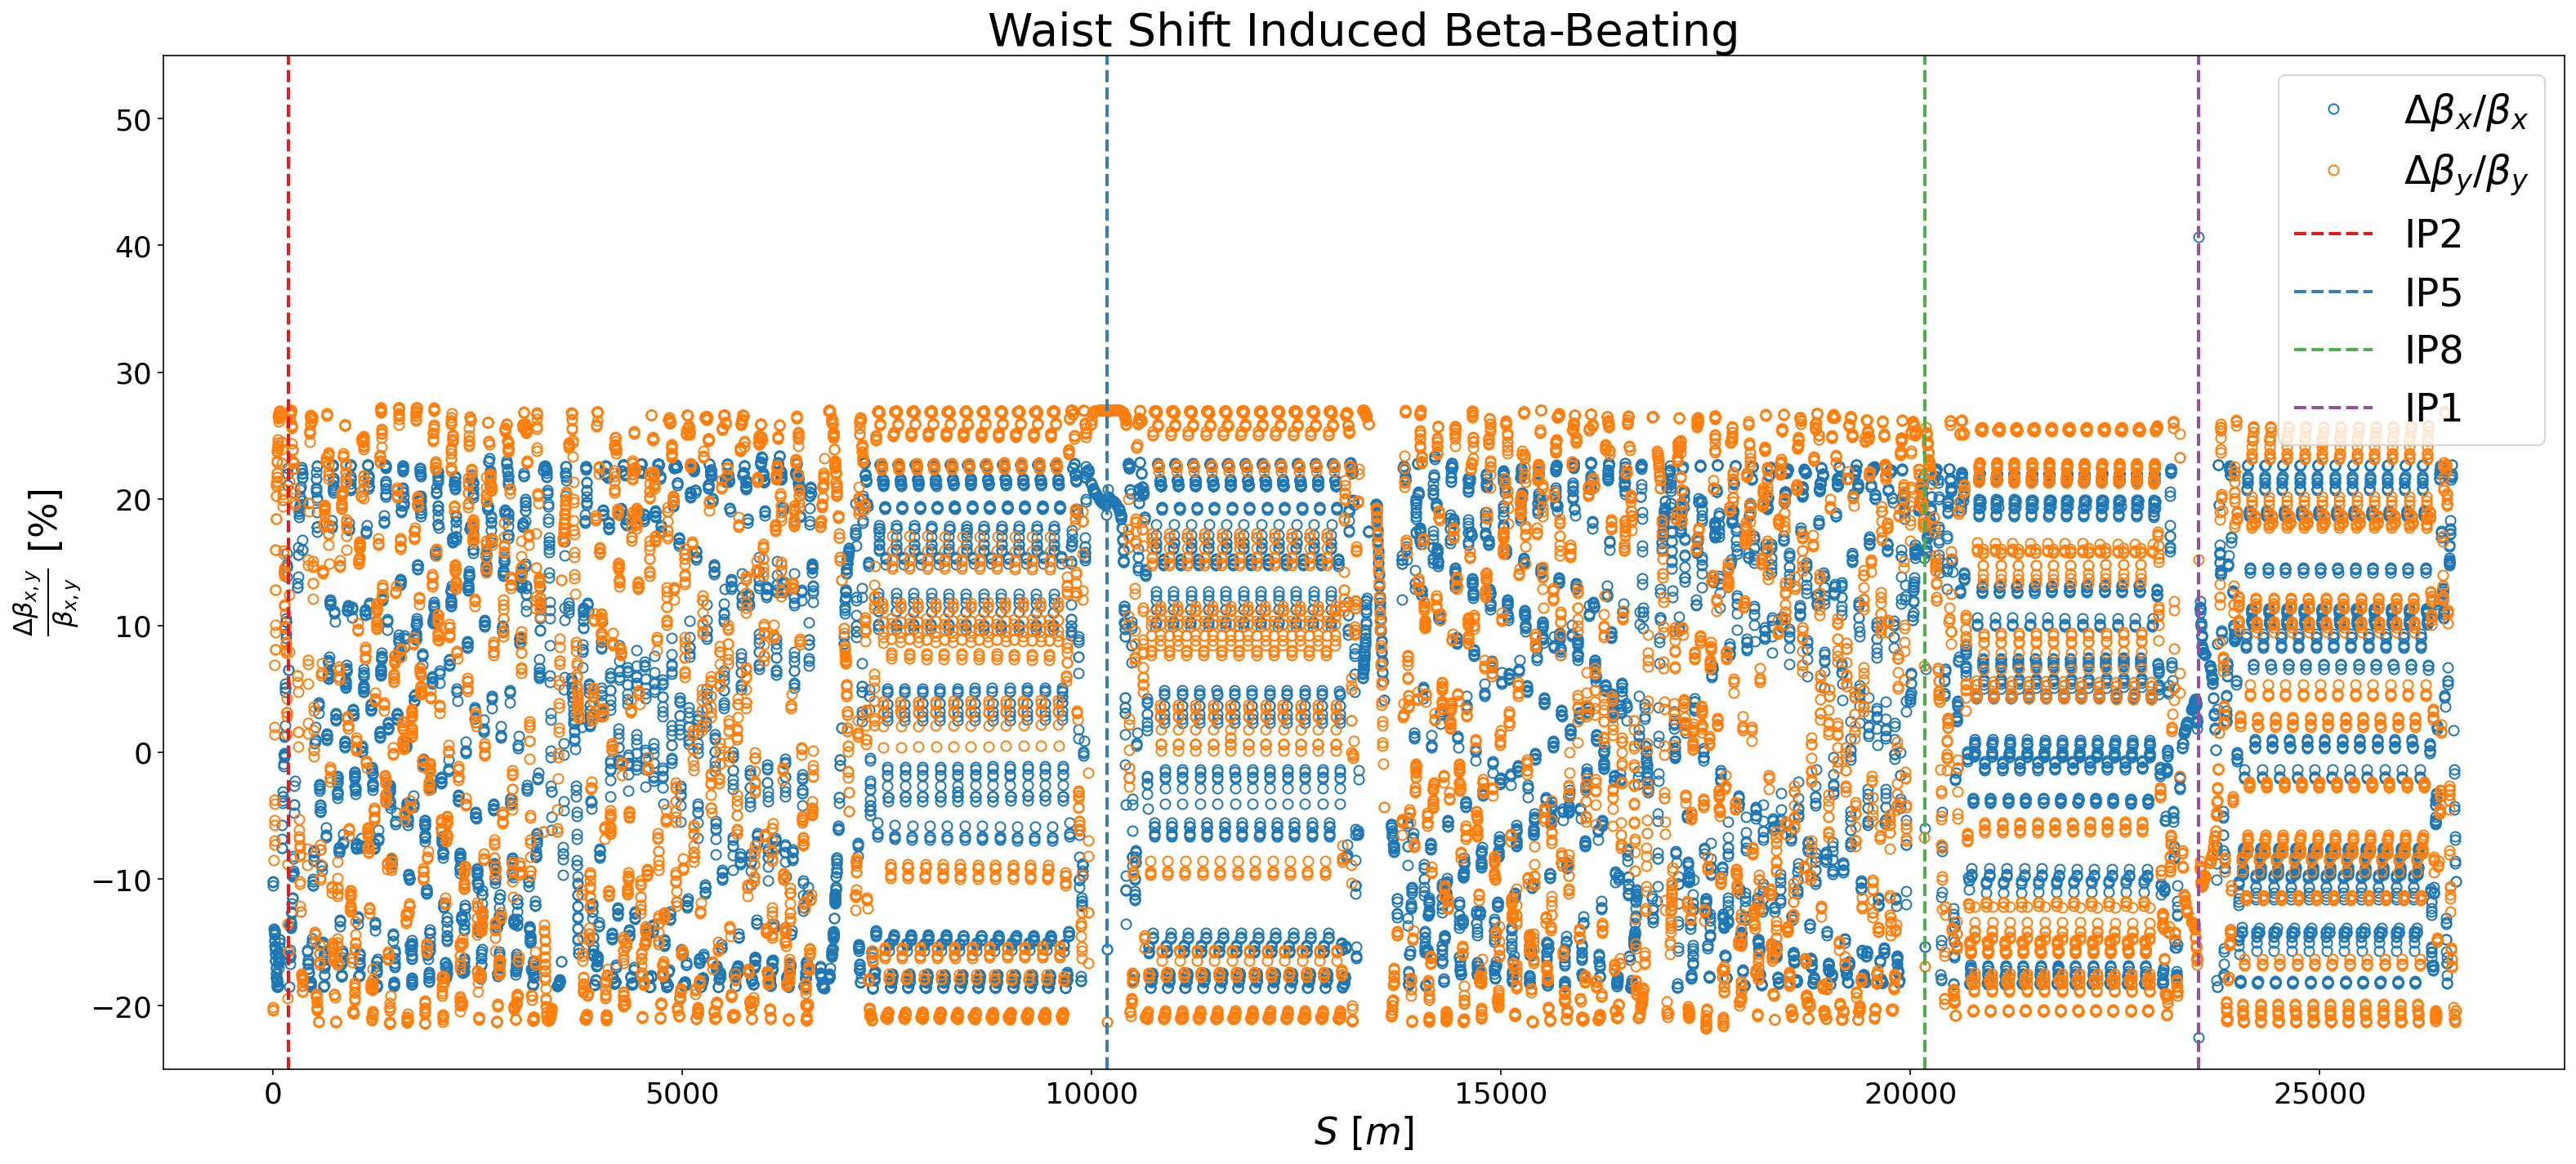

In [10]:
fig, axis = plt.subplots(figsize=FIGSIZE)
plot_waist_shift_betabeatings(axis, bare_twiss, show_ips=True)
axis.set_ylim(-25, 55)
axis.set_title("Waist Shift Induced Beta-Beating")

2022-03-01 14:51:39 | DEBUG    | rws.plotting:33 - Plotting waist shift induced beta-beating.


Text(0.5, 1.0, 'Waist Shift Induced Beta-Beating, After Matching')

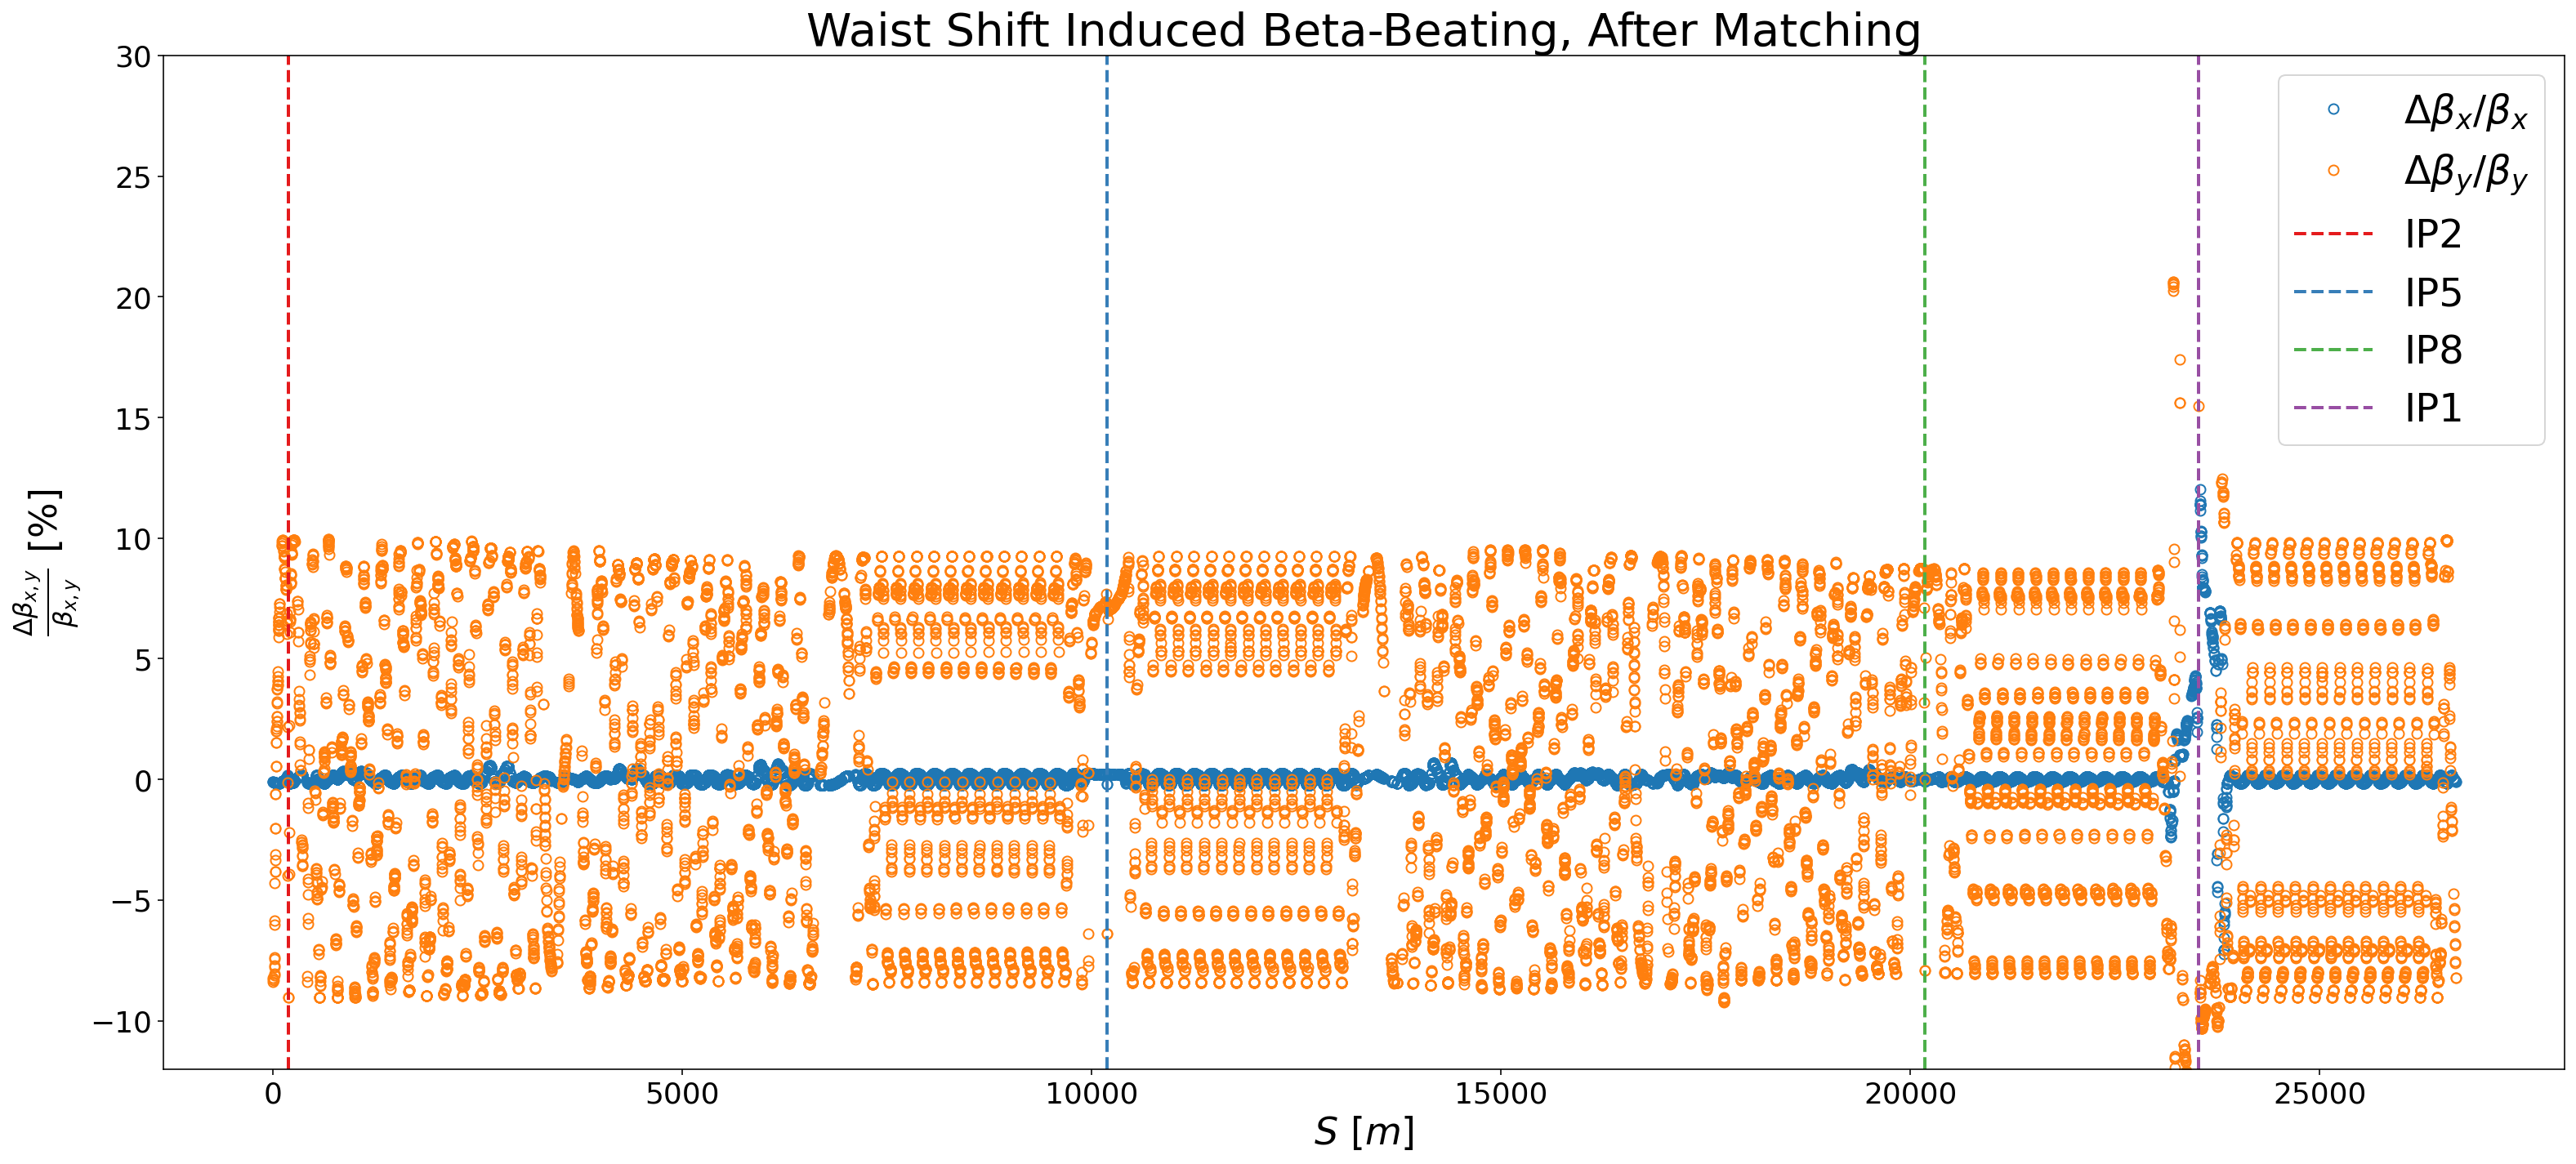

In [11]:
fig, axis = plt.subplots(figsize=FIGSIZE)
plot_waist_shift_betabeatings(axis, matched_twiss, show_ips=True)
axis.set_ylim(-12, 30)
axis.set_title("Waist Shift Induced Beta-Beating, After Matching")
# plt.xlim(19500, 20500)

2022-03-01 14:51:40 | DEBUG    | rws.plotting:72 - Plotting waist shift induced beta-beating before and after matching.
2022-03-01 14:51:40 | DEBUG    | rws.plotting:72 - Plotting waist shift induced beta-beating before and after matching.


Text(0.5, 1.0, 'Horizontal Waist Shift Induced Beta-Beating - Before vs After Matching')

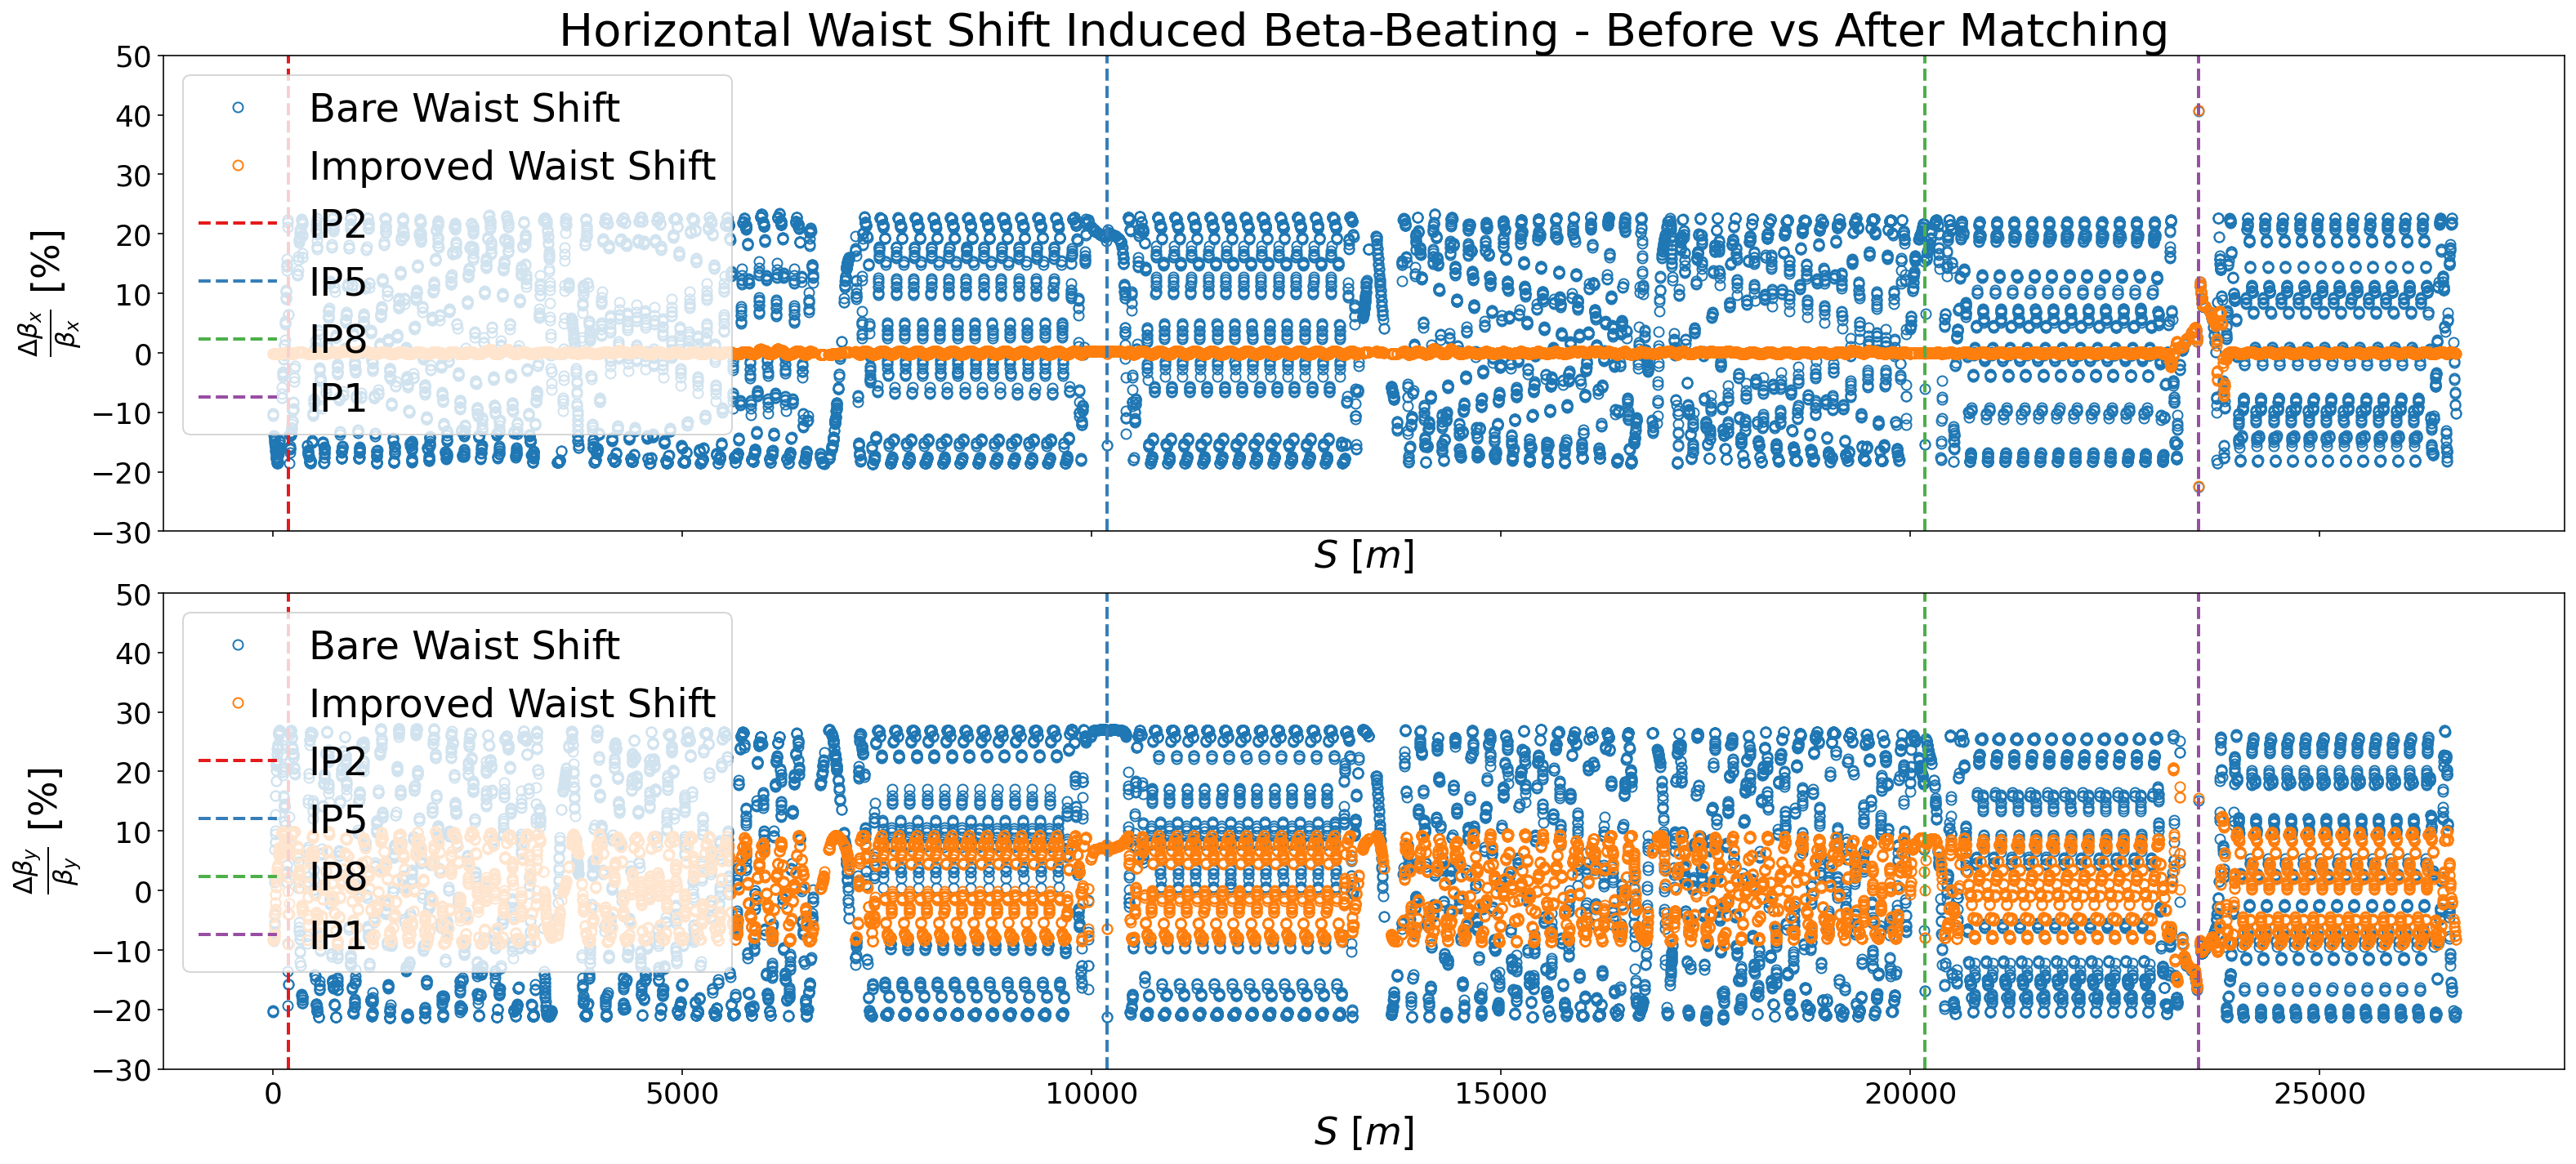

In [12]:
fig, (axx, axy) = plt.subplots(2, 1, figsize=FIGSIZE, sharex=True)
plot_waist_shift_betabeatings_comparison(axx, bare_twiss, matched_twiss, column="BBX", show_ips=True)
plot_waist_shift_betabeatings_comparison(axy, bare_twiss, matched_twiss, column="BBY", show_ips=True)
axx.set_ylim(-30, 50)
axy.set_ylim(-30, 50)
axx.set_title("Horizontal Waist Shift Induced Beta-Beating - Before vs After Matching")
# plt.xlim(19500, 20500)

2022-03-01 14:51:40 | DEBUG    | rws.plotting:118 - Plotting beta functions for nominal, bare waist shift and improved waist shift scenarii.
2022-03-01 14:51:40 | DEBUG    | rws.plotting:118 - Plotting beta functions for nominal, bare waist shift and improved waist shift scenarii.


Text(0.5, 0, 'S [m]')

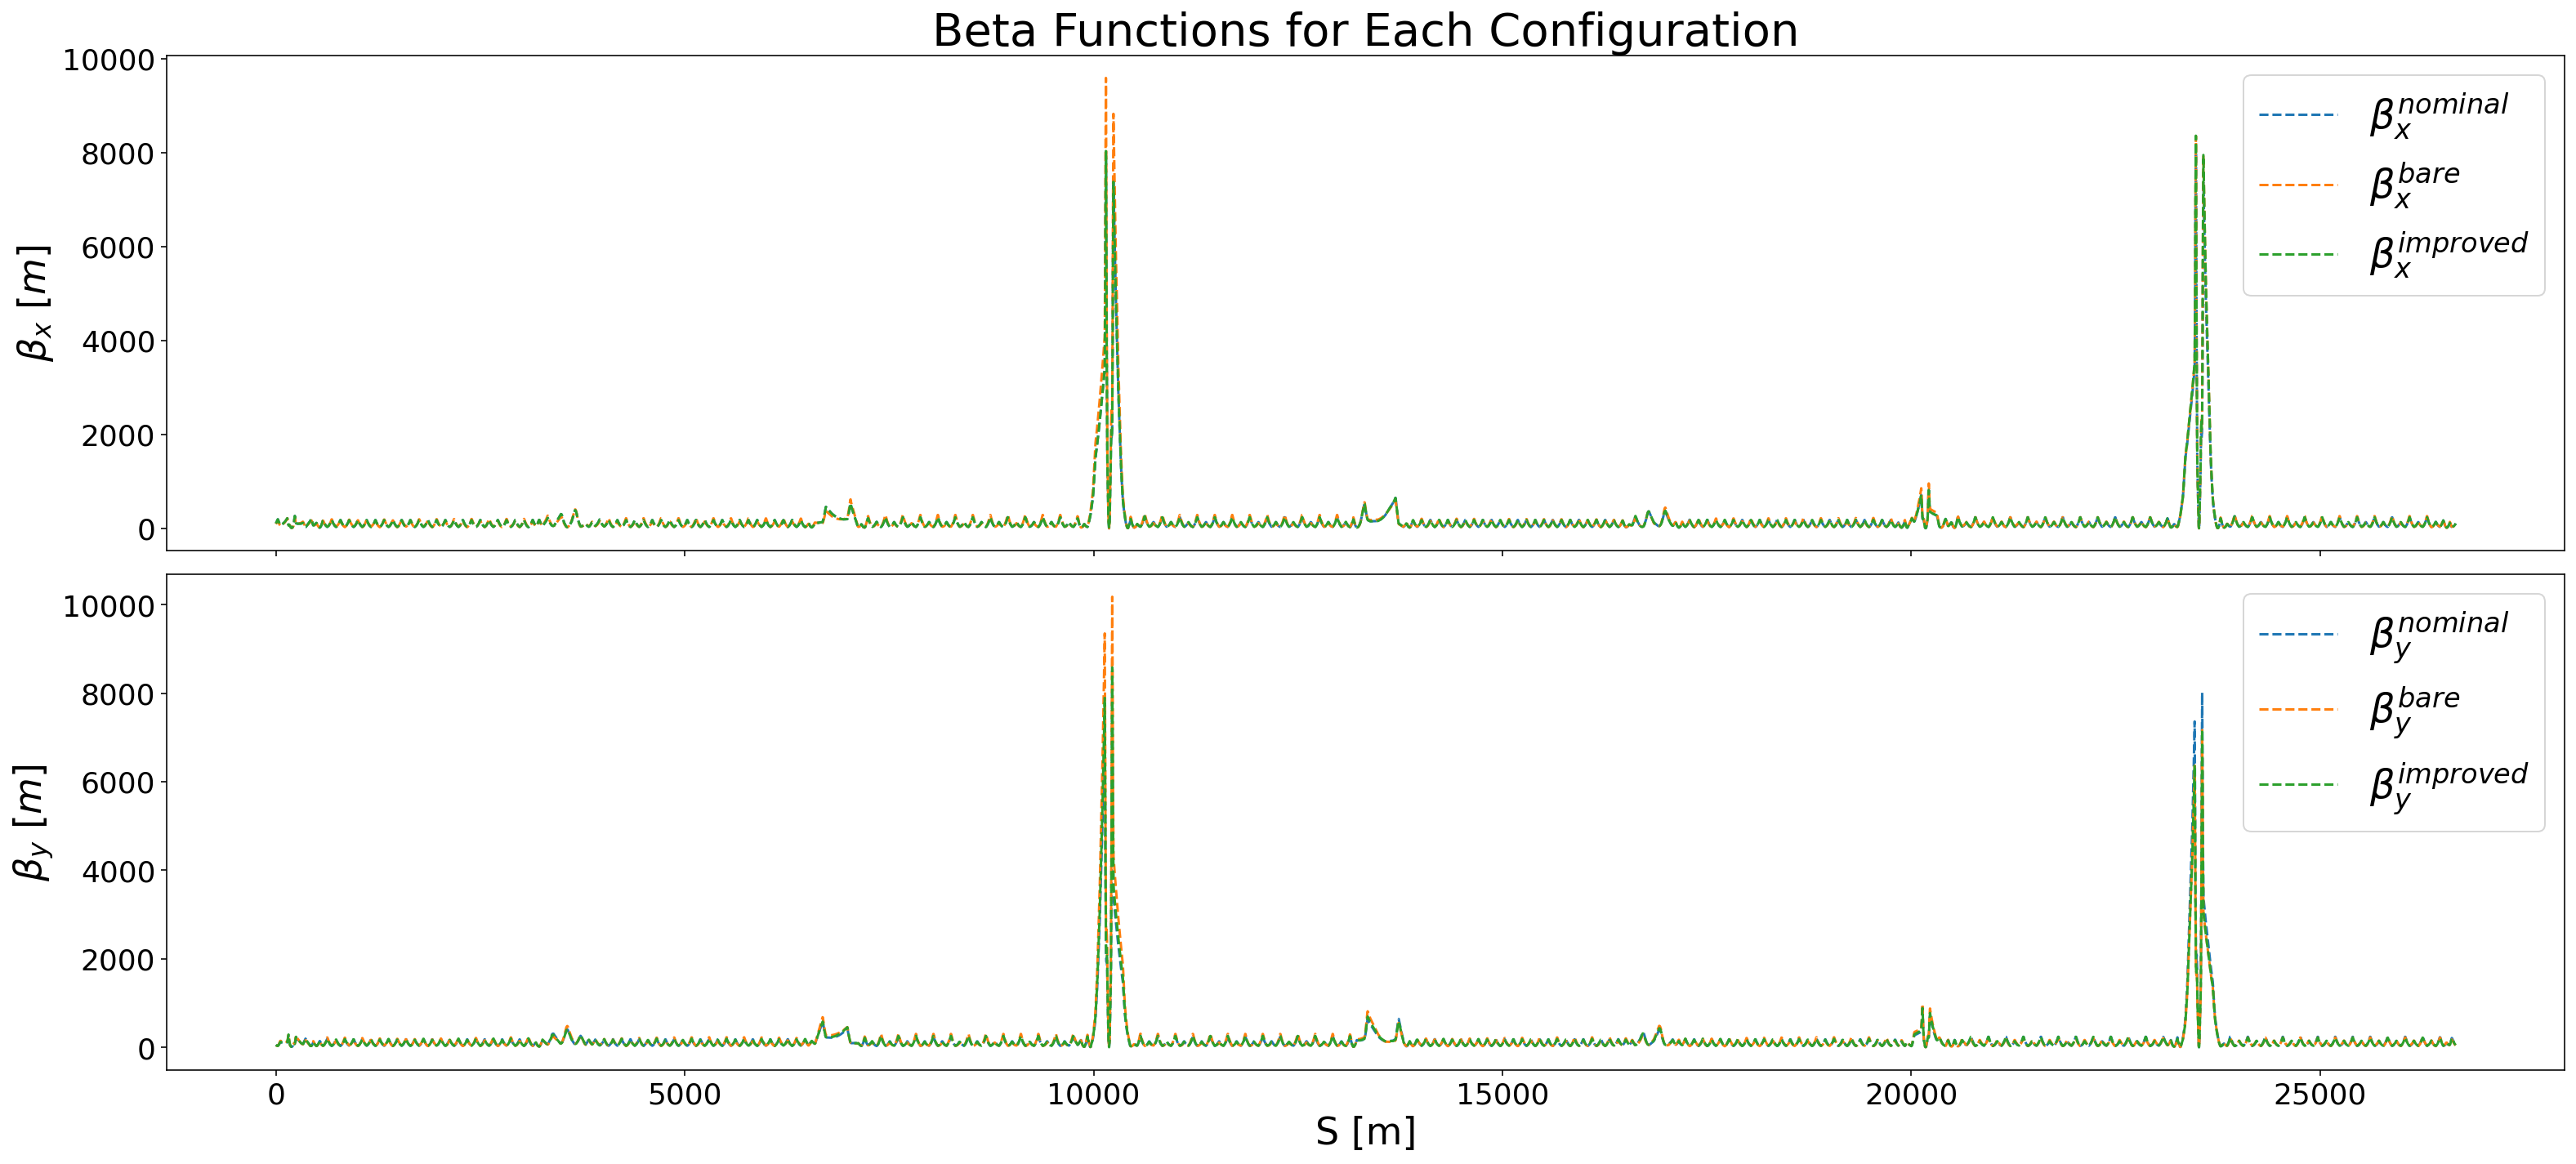

In [13]:
fig, (axx, axy) = plt.subplots(2, 1, figsize=FIGSIZE, sharex=True)

plot_betas_comparison(axx, nominal_twiss, bare_twiss, matched_twiss, column="BETX")
plot_betas_comparison(axy, nominal_twiss, bare_twiss, matched_twiss, column="BETY")
axx.set_title("Beta Functions for Each Configuration")
axy.set_xlabel("S [m]")
# plt.xlim(19500, 20500)

2022-03-01 14:51:41 | DEBUG    | rws.plotting:174 - Plotting beta functions deviation from nominal, for bare waist shift and improved waist shift scenarii.
2022-03-01 14:51:41 | DEBUG    | rws.plotting:174 - Plotting beta functions deviation from nominal, for bare waist shift and improved waist shift scenarii.


Text(0.5, 0, 'S [m]')

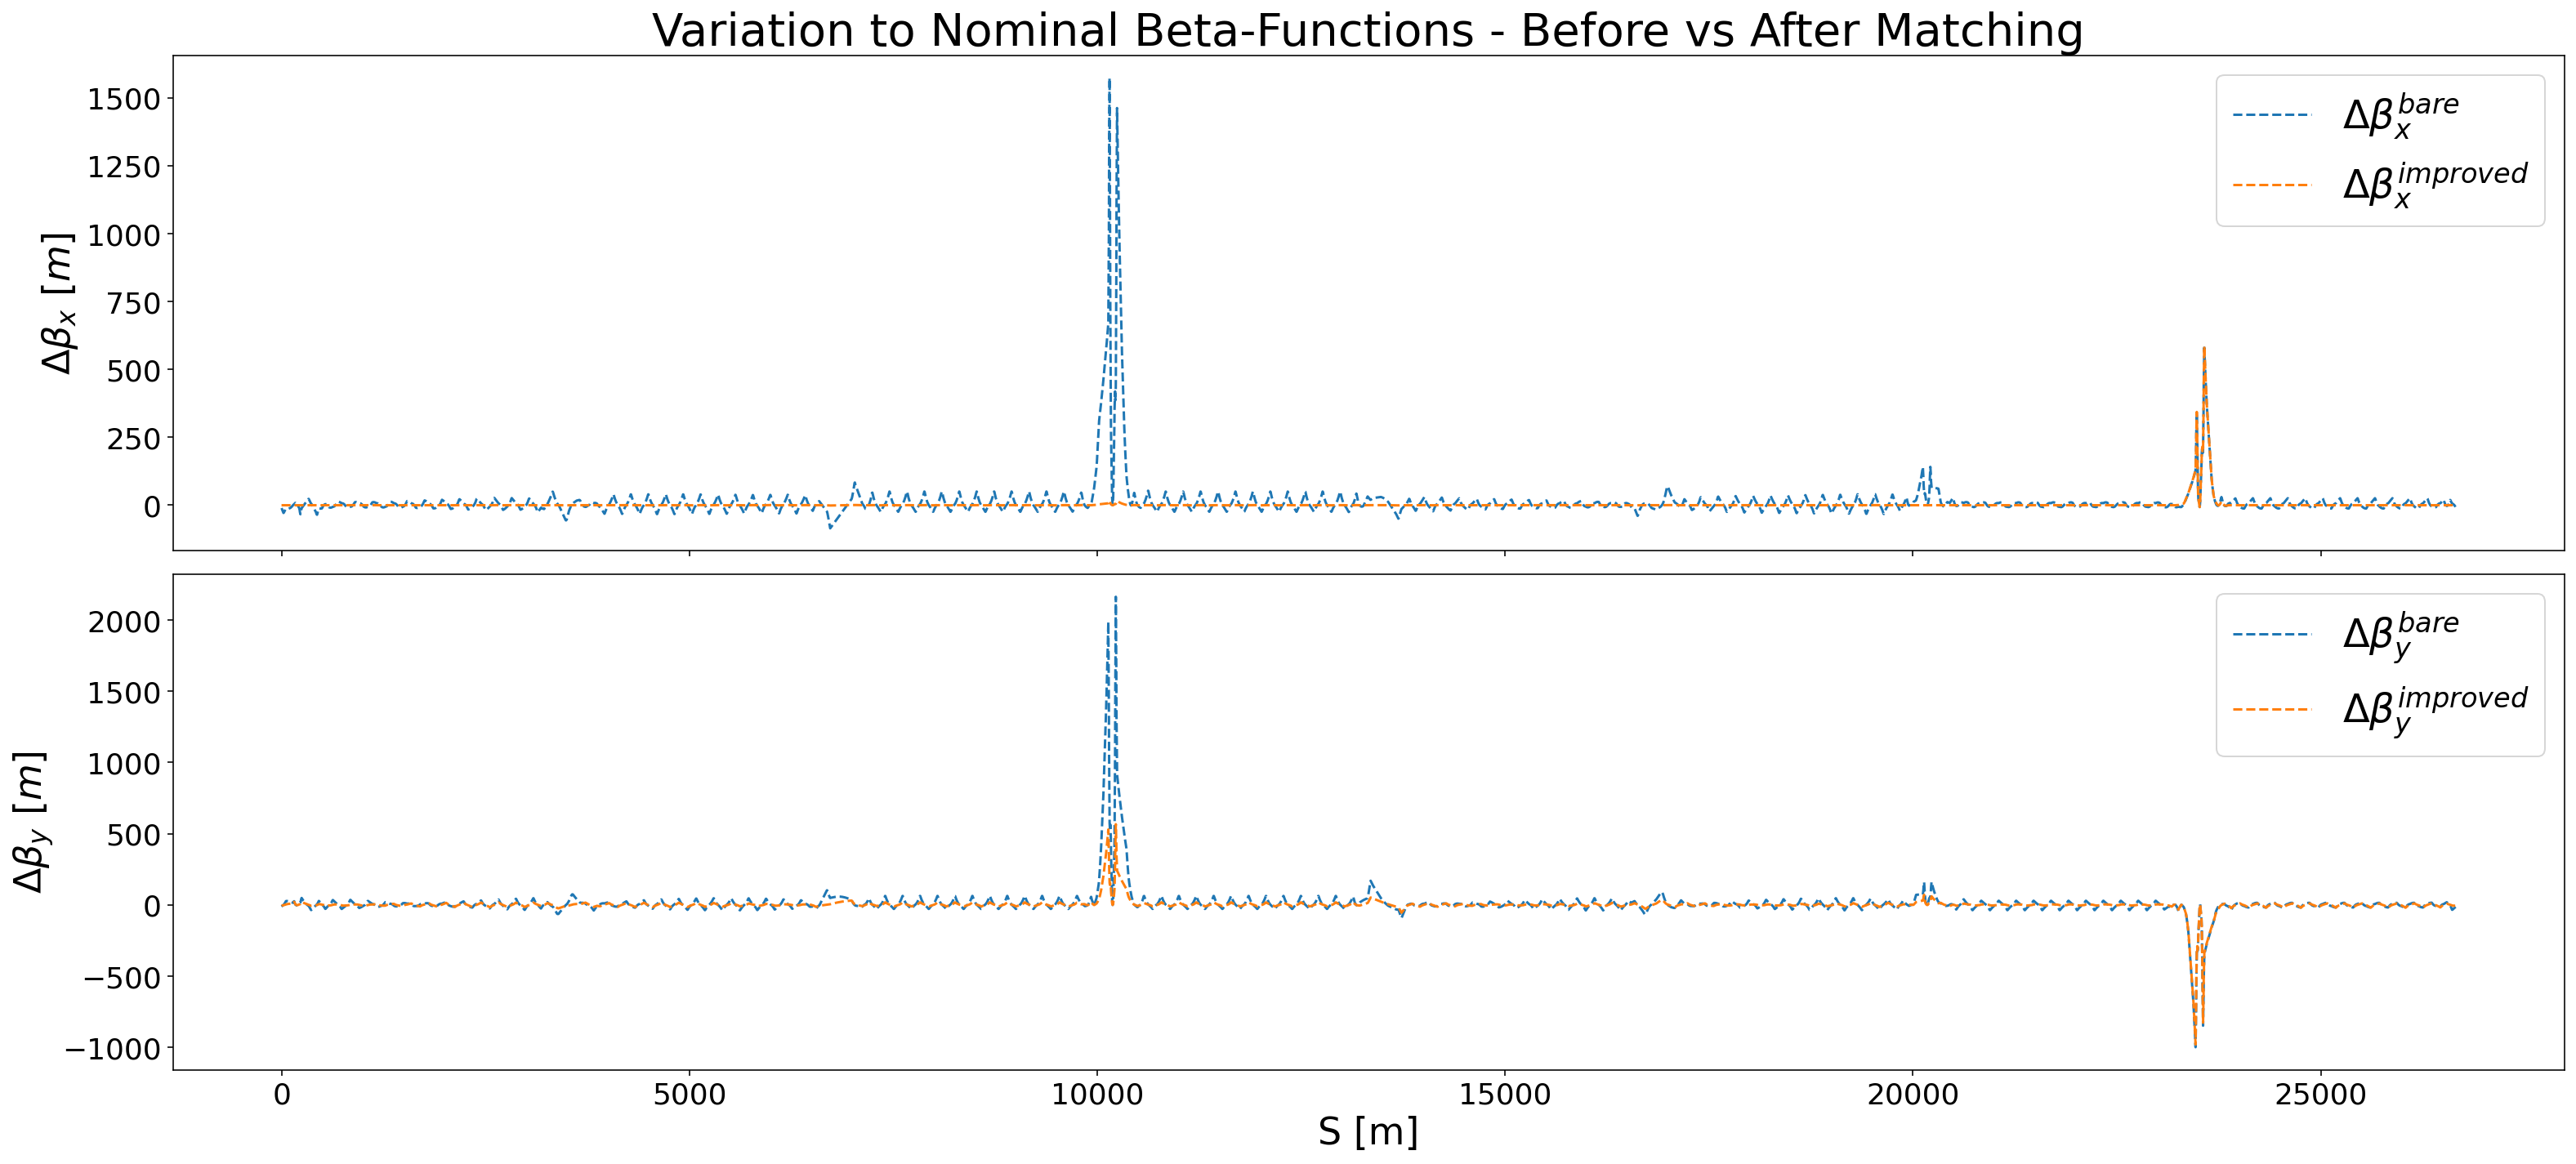

In [14]:
# Also get nominal with twiss.get_twiss_tfs(madx) to make things the same
fig, (axx, axy) = plt.subplots(2, 1, figsize=FIGSIZE, sharex=True)

plot_betas_deviation(axx, nominal_twiss, bare_twiss, matched_twiss, column="BETX")
plot_betas_deviation(axy, nominal_twiss, bare_twiss, matched_twiss, column="BETY")
axx.set_title("Variation to Nominal Beta-Functions - Before vs After Matching")
axy.set_xlabel("S [m]")
# plt.xlim(19500, 20500)

2022-03-01 14:53:12 | DEBUG    | rws.plotting:228 - Plotting phase advances for nominal, bare waist shift and improved waist shift scenarii.
2022-03-01 14:53:12 | DEBUG    | rws.plotting:228 - Plotting phase advances for nominal, bare waist shift and improved waist shift scenarii.


Text(0.5, 0, 'S [m]')

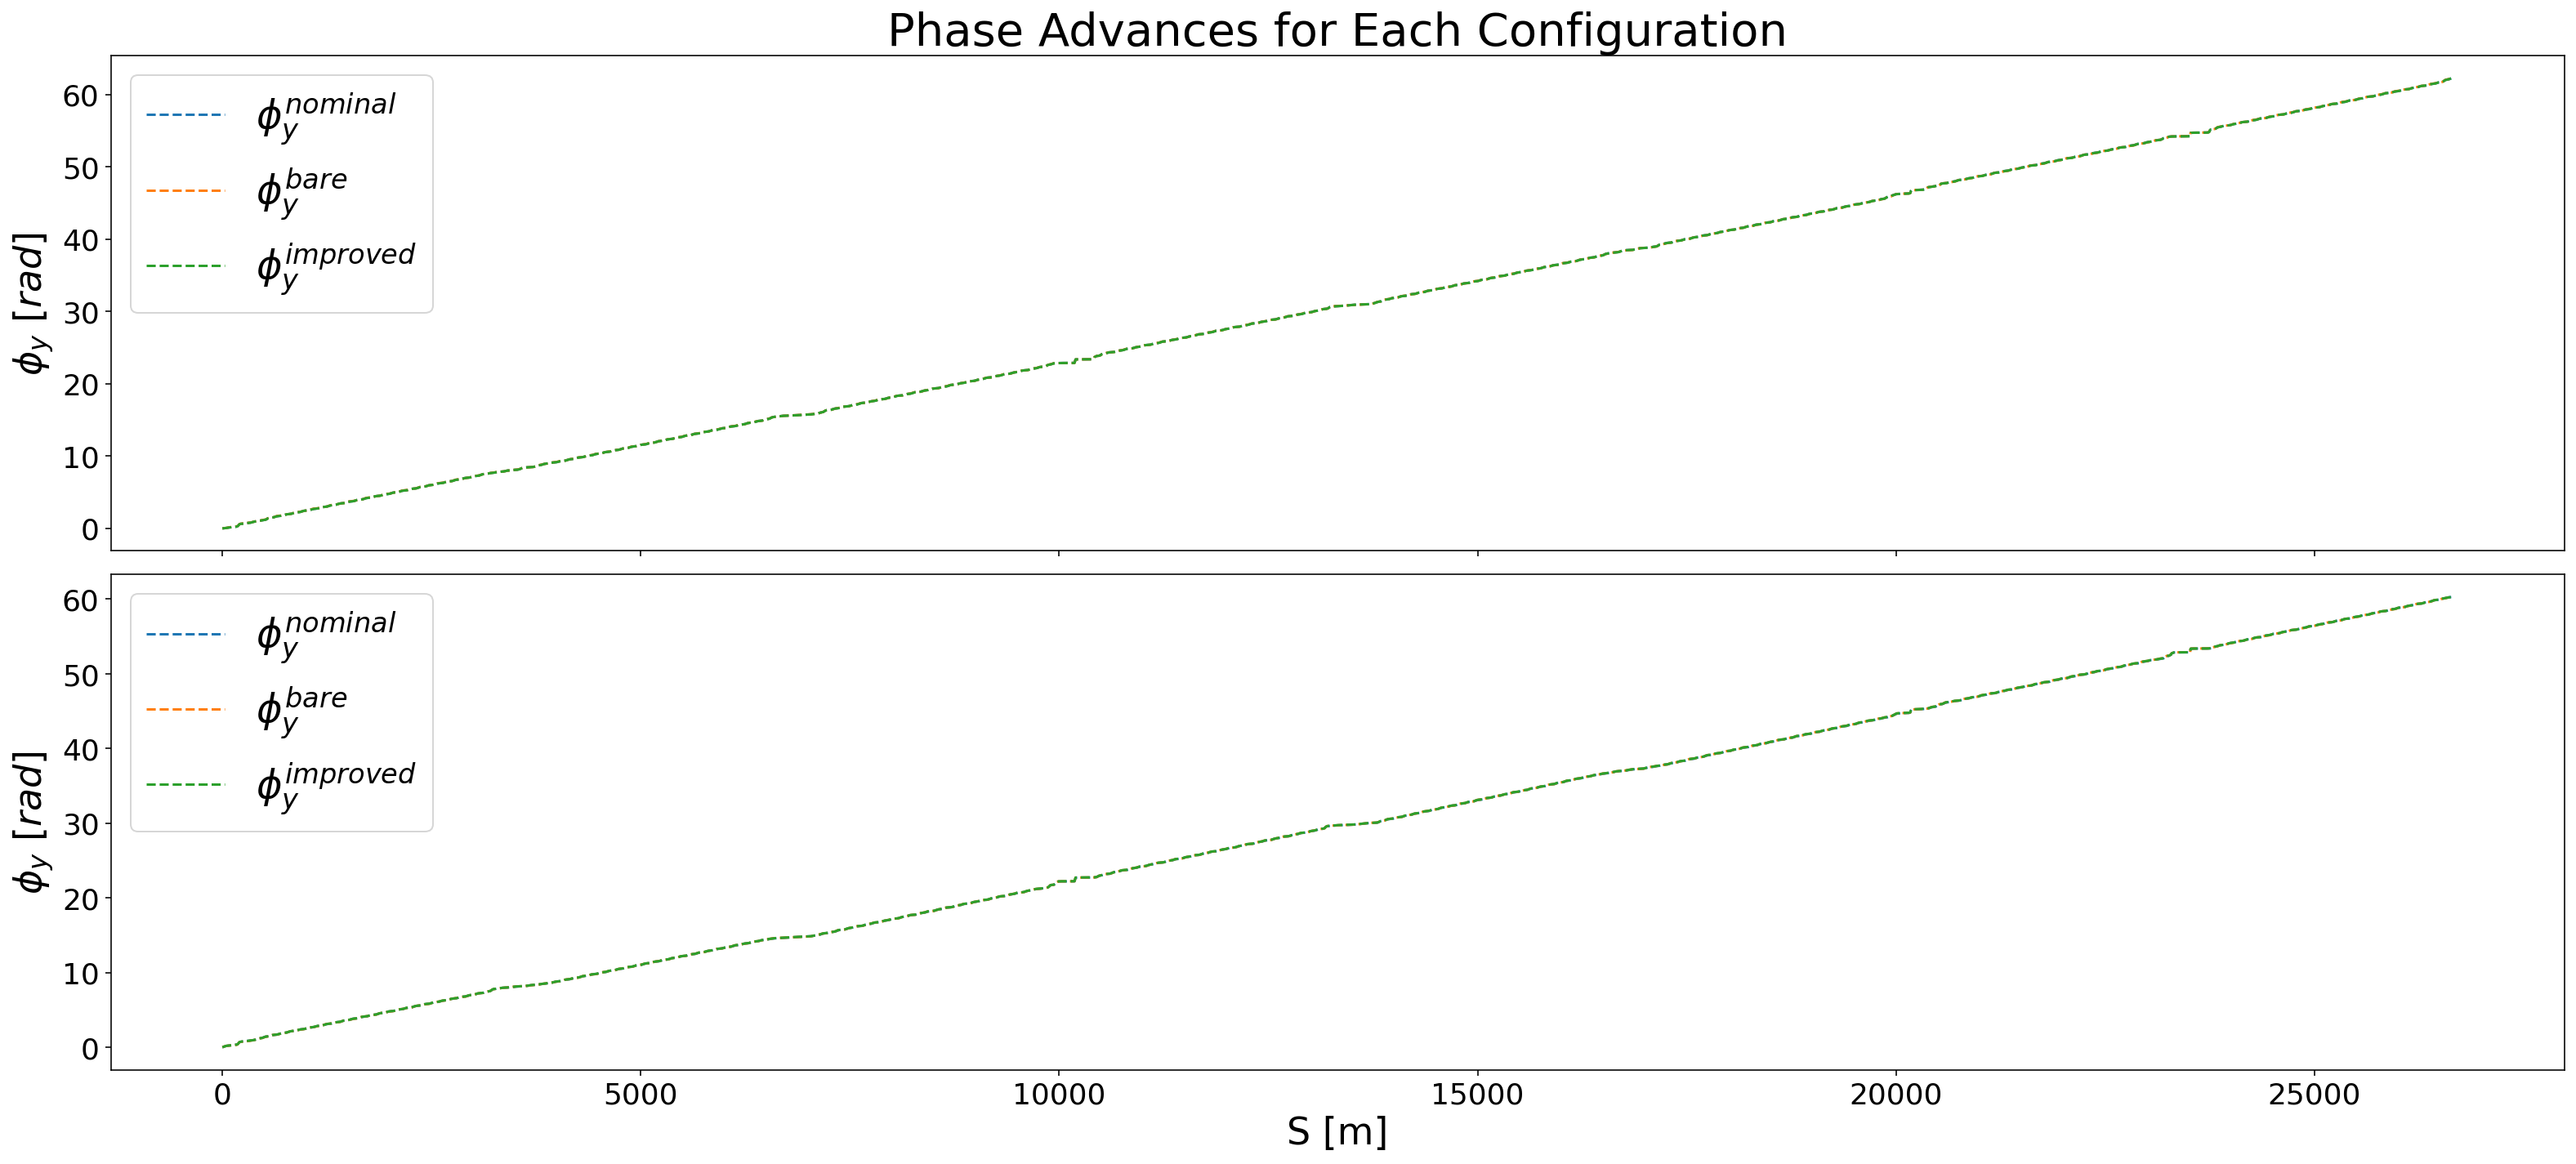

In [19]:
fig, (axx, axy) = plt.subplots(2, 1, figsize=FIGSIZE, sharex=True)

plot_phase_advances_comparison(axx, nominal_twiss, bare_twiss, matched_twiss, column="MUX")
plot_phase_advances_comparison(axy, nominal_twiss, bare_twiss, matched_twiss, column="MUY")
axx.set_title("Phase Advances for Each Configuration")
axy.set_xlabel("S [m]")
# plt.xlim(19500, 20500)

2022-03-01 14:53:21 | DEBUG    | rws.plotting:286 - Plotting phase advances for nominal, bare waist shift and improved waist shift scenarii.
2022-03-01 14:53:21 | DEBUG    | rws.plotting:286 - Plotting phase advances for nominal, bare waist shift and improved waist shift scenarii.


Text(0.5, 0, 'S [m]')

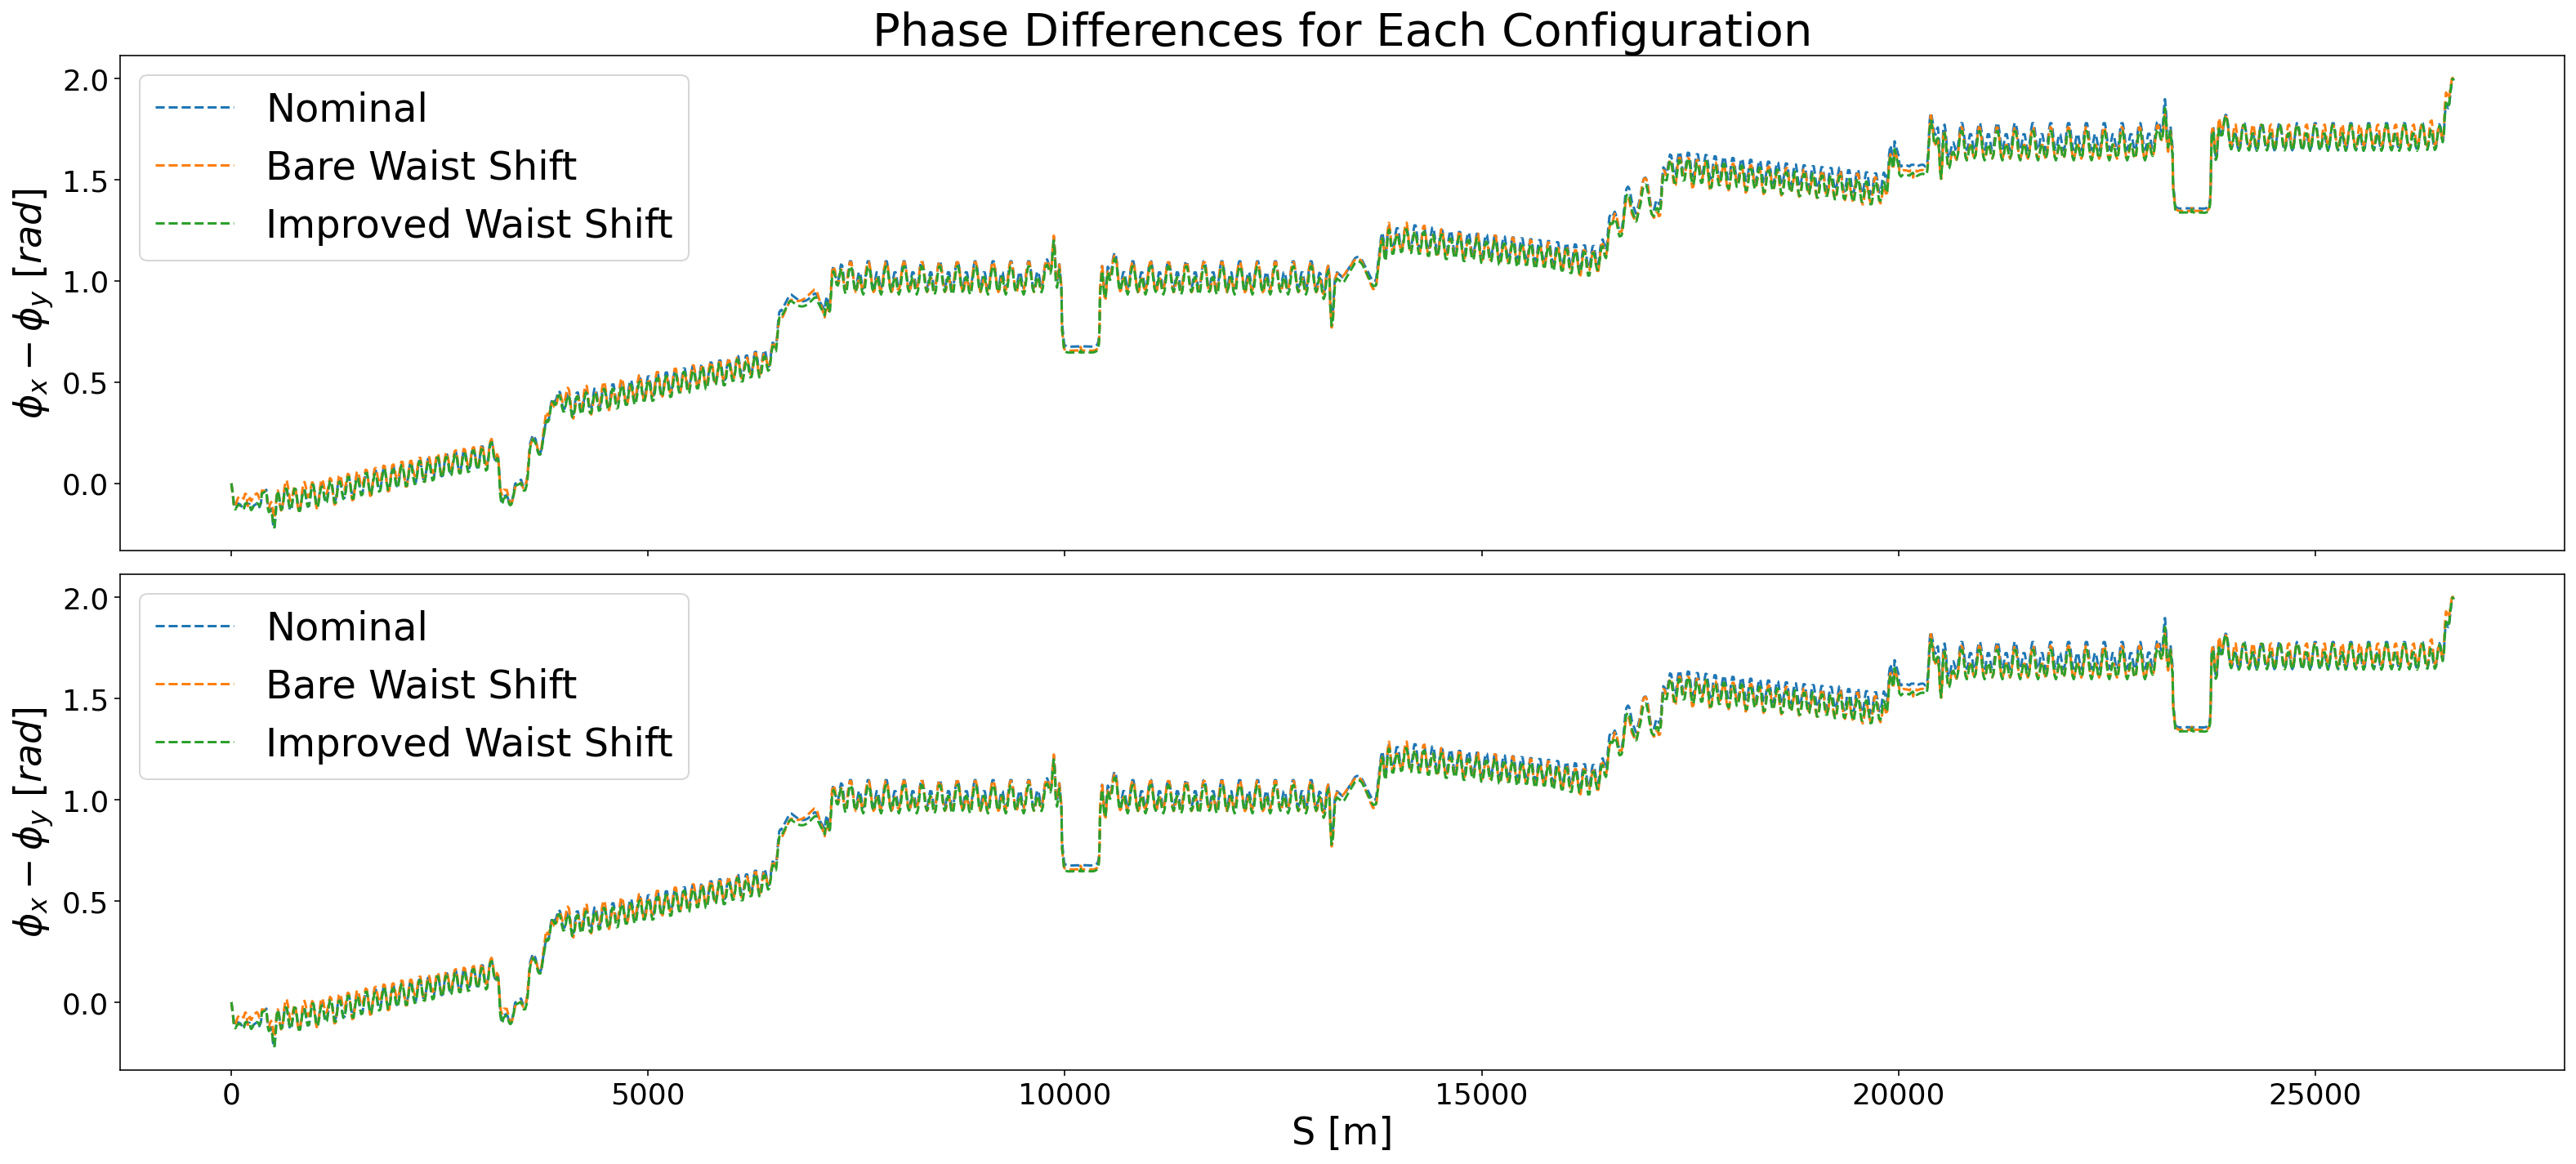

In [20]:
fig, (axx, axy) = plt.subplots(2, 1, figsize=FIGSIZE, sharex=True)

plot_phase_differences(axx, nominal_twiss, bare_twiss, matched_twiss)
plot_phase_differences(axy, nominal_twiss, bare_twiss, matched_twiss)
axx.set_title("Phase Differences for Each Configuration")
axy.set_xlabel("S [m]")
# plt.xlim(19500, 20500)

---

In [17]:
powering_tfs = twiss.get_twiss_tfs(madx)
ip1s = powering_tfs.S["IP1"]
powering_tfs = powering_tfs.loc[powering_tfs.S.between(ip1s - 457, ip1s + 457)]
powering_tfs = powering_tfs.loc[powering_tfs.KEYWORD == "quadrupole"]
powering_tfs["K1"] = powering_tfs.K1L / powering_tfs.L
powering_tfs = powering_tfs[["K1", "K1L"]]
powering_tfs = powering_tfs.drop(
    index=[
        "MQTLI.11L1.B1",
        "MQTLI.11R1.B1",
        "MQ.11L1.B1",
        "MQ.11R1.B1",
        "MQXB.A2L1",
        "MQXB.A2R1",
        "MQXB.B2L1",
        "MQXB.B2R1",
        "MQSX.3L1",
        "MQSX.3R1",
        "MQXA.3L1",
        "MQXA.3R1",
    ]
)
powering_tfs

# print(powering_tfs.to_latex())

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
        26658.8832                 -0    0.0003485045729        53.56680696 

                q1                dq1            betxmax              dxmax 
             62.31        1.998995207        8356.279987        2.975064713 

             dxrms             xcomax             xcorms 2022-03-01 14:51:42 | INFO     | pyhdtoolkit.cpymadtools.twiss:121 - Exporting internal TWISS and SUMM tables to TfsDataFrame
                q2 
       1.504083213                  0                  0              60.32 

               dq2            betymax              dymax              dyrms 
       1.999594292        8579.946809                 -0                  0 

            ycomax             ycorms             deltap   

Headers:
    LENGTH: 26658.88319999891
    ORBIT5: -0.0
    ALFA: 0.00034850457286833374
    ...
    NFLIPS: 0.0
    DQMIN: 0.0
    DQMIN_PHASE: 0.0

                    K1       K1L
NAME                            
MQML.10L1.B1  0.006991  0.033559
MQMC.9L1.B1  -0.006495 -0.015588
MQM.9L1.B1   -0.006495 -0.022083
MQML.8L1.B1   0.007959  0.038202
MQM.B7L1.B1  -0.007810 -0.026556
MQM.A7L1.B1  -0.007810 -0.026556
MQML.6L1.B1   0.000489  0.002347
MQML.5L1.B1  -0.001282 -0.006154
MQY.4L1.B1    0.002134  0.007254
MQXA.1L1     -0.008721 -0.055552
MQXA.1R1      0.008633  0.054995
MQY.4R1.B1   -0.002224 -0.007563
MQML.5R1.B1   0.001105  0.005305
MQML.6R1.B1  -0.000371 -0.001781
MQM.A7R1.B1   0.007585  0.025790
MQM.B7R1.B1   0.007585  0.025790
MQML.8R1.B1  -0.007297 -0.035024
MQMC.9R1.B1   0.006679  0.016029
MQM.9R1.B1    0.006679  0.022708
MQML.10R1.B1 -0.006623 -0.031792

In [18]:
madx.exit()


  Number of warnings: 0

  ++++++++++++++++++++++++++++++++++++++++++++
  +          MAD-X finished normally         +
  ++++++++++++++++++++++++++++++++++++++++++++


---

- Plot the global phase advance in each case too (mux/muy versus S)
- Can also do mux - muy because it drives the f1001

At the end:
- have the better waist shift in
- put in a little bit of crossing angles and see that the orbit starts changing
- try to do a bit of correction (`CORRECT` in madx)

Caveat: would have to disable the use of the crossing angle correctors knobs